# Moondream for bounding-box segmentation

In this notebook we will use the vision language model [moondream](https://huggingface.co/vikhyatk/moondream2) to determine bounding-boxes around objects.

Installation (Windows):
* Download vips-dev-w64-all-8.16.1.zip from [here](https://github.com/libvips/build-win64-mxe/releases/tag/v8.16.1), unzip it, and add its subfolder `bin` to the PATH environment variable.
* `pip install einops pyvips`

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image
from image_utilities import numpy_to_bytestream, extract_json, generate_spots
from tqdm import tqdm
import stackview

model = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2",
    revision="2025-04-14",
    trust_remote_code=True,
    # Comment to run on CPU. To use the GPU, you need about 5 GB of GPU Memory.
    device_map={"": "cuda"}
)

## Human mitosis


[[ 8  8  8 ... 10  9  9]
 [ 8  8  7 ... 10 11 10]
 [ 9  8  8 ...  9 10  9]
 ...
 [ 9  8  9 ...  9  9  8]
 [ 9  8  8 ...  9  9  9]
 [ 8  8  9 ... 10  9  9]]
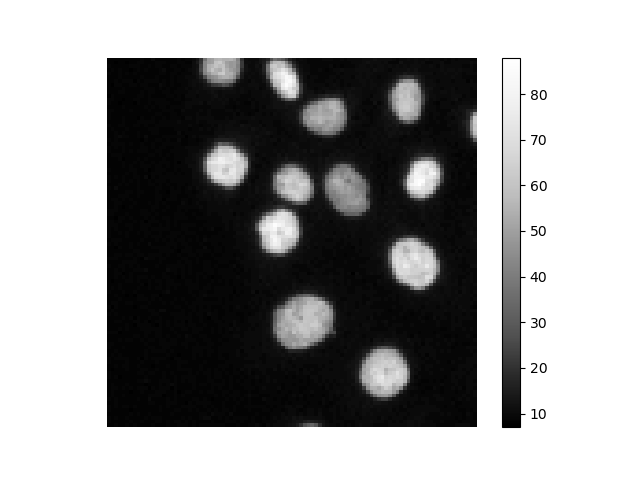
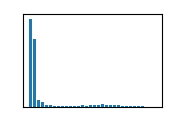

In [2]:
import stackview
from skimage import data
import numpy as np

# Load the human mitosis dataset
image = data.human_mitosis()[:100, :100]

# Display the image
stackview.insight(image)

In [3]:
pil_image = Image.fromarray(image)

encoded_image = model.encode_image(pil_image)

In [4]:
bb = model.detect(encoded_image, "Mark all the bright blobs individually")["objects"]
print(f"Found {len(bb)} bright spot(s)")

Found 11 bright spot(s)


In [5]:
for b in bb:
    b["x"] = b["x_min"]
    b["y"] = b["y_min"]
    b["width"] = b["x_max"]-b["x_min"]
    b["height"] = b["y_max"]-b["y_min"]
bb[:2]

[{'x_min': 0.2584344260394573,
  'y_min': 0.0017580389976501465,
  'x_max': 0.3743780739605427,
  'y_max': 0.09199196100234985,
  'x': 0.2584344260394573,
  'y': 0.0017580389976501465,
  'width': 0.11594364792108536,
  'height': 0.09023392200469971},
 {'x_min': 0.42661894857883453,
  'y_min': 0.0029355064034461975,
  'x_max': 0.5265060514211655,
  'y_max': 0.1220644935965538,
  'x': 0.42661894857883453,
  'y': 0.0029355064034461975,
  'width': 0.09988710284233093,
  'height': 0.1191289871931076}]

[[[ 3  3  3]
  [ 3  3  3]
  [ 3  3  3]
  ...
  [ 9  9  9]
  [ 6  6  6]
  [ 6  6  6]]

 [[ 3  3  3]
  [ 3  3  3]
  [ 0  0  0]
  ...
  [ 9  9  9]
  [12 12 12]
  [ 9  9  9]]

 [[ 6  6  6]
  [ 3  3  3]
  [ 3  3  3]
  ...
  [ 6  6  6]
  [ 9  9  9]
  [ 6  6  6]]

 ...

 [[ 6  6  6]
  [ 3  3  3]
  [ 6  6  6]
  ...
  [ 6  6  6]
  [ 6  6  6]
  [ 3  3  3]]

 [[ 6  6  6]
  [ 3  3  3]
  [ 3  3  3]
  ...
  [ 6  6  6]
  [ 6  6  6]
  [ 6  6  6]]

 [[ 3  3  3]
  [ 3  3  3]
  [ 6  6  6]
  ...
  [ 9  9  9]
  [ 6  6  6]
  [ 6  6  6]]]
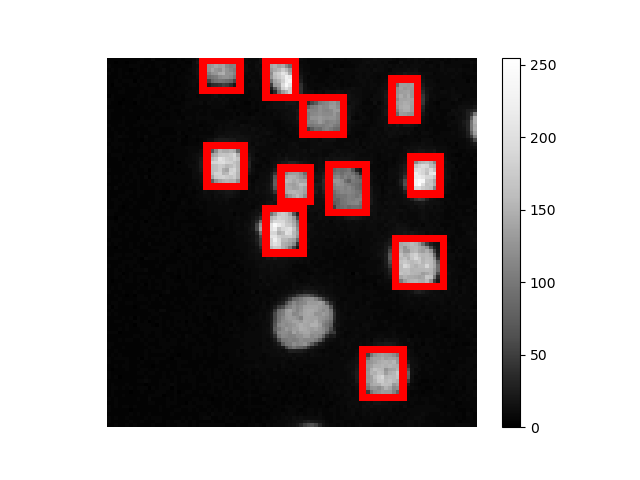
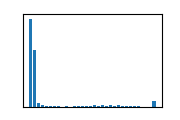

In [6]:
stackview.add_bounding_boxes(image, bb)